In [1]:
import os, os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *

import random


In [2]:
create_new = True
printing = True
removing_cols = True


data_path = Path('/data/cresswellclayec/DCA_ER/Pfam-A.full')
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir

out_dir = '%s/protein_data/di/' % biowulf_dir
processed_data_dir = "%s/protein_data/data_processing_output" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir
furano_dir = '%s/furano_periwal_prot' % DCA_ER_dir
line1_dir = "%s/protein_data/" % furano_dir

pfam_dir = "/fdb/fastadb/pfam"
line1_colors = [(.71,.32,.8),(1.0,.65,0.),(.55,0.,0.),(0,.8,.8),(0.,.55,.55),
                  (1.0,.1,.58),(0.,0.,.80),(0.4,0.4,0.4)]


In [3]:
pdb_protein = False
if pdb_protein:
    pdb_id = "1zdr"
    prody_df = pd.read_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))                                           
    pdb2msa_row = prody_df.iloc[0]
    pdb_id = pdb2msa_row['PDB ID']                                                                        
    pfam_id = pdb2msa_row['Pfam']
    print(pdb_id, pfam_id)
    n_cpus = 20

    ER_di = np.load("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id))
    PMF_di_data = np.load("%s/%s_%s_PMF_di.npy" % (out_dir, pdb_id, pfam_id),allow_pickle=True)              
    PLM_di_data = np.load("%s/%s_%s_PLM_di.npy" % (out_dir, pdb_id, pfam_id),allow_pickle=True)

    s0 = np.load("%s/%s_%s_preproc_msa.npy" % (processed_data_dir, pfam_id, pdb_id))                         
    s_index = np.load("%s/%s_%s_preproc_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))                 
    #pdb_s_index = np.load("%s/%s_%s_preproc_pdb_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))        
    removed_cols = np.load("%s/%s_%s_removed_cols.npy" % (processed_data_dir, pfam_id, pdb_id))              
    ref_seq = np.load("%s/%s_%s_preproc_refseq.npy" % (processed_data_dir, pfam_id, pdb_id))      
    
    w_file = "%s/%s_%s_w.npy" % (processed_data_dir, pdb_id, pfam_id) 
    w = np.load(w_file)
    print('wER shape: ',w.shape)

else:
    msa_1 = 1
    msa_2 = msa_1 + 1
    colors = [(.71,.32,.8),(1.0,.65,0.),(.55,0.,0.),(0,.8,.8),(0.,.55,.55),\
                  (1.0,.1,.58),(0.,0.,.80),(0.4,0.4,0.4)]
    # use LINE1 protein
    all_seqs = []
    with open('furano_periwal_prot/protein_data/all_seqs.fa', 'rU') as f:
        seq_iter = SeqIO.parse(f,'fasta')
        for seq in seq_iter:
            all_seqs.append(seq)

    lp_msas = []
    lp_fa_prefix = 'furano_periwal_prot/protein_data/'
    lp_names = ['L1Pa1', 'L1Pa2', 'L1Pa3', 'L1Pa4', 'L1Pa5', 'L1Pa6', 'L1Pa7' ]
    total_len = 0
    lp_files = ['cls1.1.fasta','cls1.2.fasta','cls123.3.fasta','cls1ab234.4.fasta','cls123.5.fasta','cls1abc234.6.fasta','cls123.7.fasta']
    lp_ids = []
    for i,filename in enumerate(lp_files):
        lp_msas.append([])
        lp_ids.append([])
#         print('Loading MSA for ',lp_names[i])
        with open(lp_fa_prefix+filename, 'rU') as f:
            seq_iter = SeqIO.parse(f,'fasta')
            for seq in seq_iter:
    #             print(seq)
                lp_msas[-1].append(seq.seq) 
                lp_ids[-1].append(seq.id)
        f.close()
    #     print(lp_msas[-1][0][:5])
#         print(len(lp_msas[-1]))
        total_len += len(lp_msas[-1])
#     print('number of all individual LPa MSA sequences: ',total_len)
#     print('number of all aligned sequences: ',len(all_seqs))

    family_ref = []
    family_indx = []
    for ii,ids in enumerate(lp_names):
        family_indx.append([])
    for i,seq in enumerate(all_seqs):
        found = False
        for j,ids in enumerate(lp_ids):
            if seq.id in ids:
                family_ref.append(j)
                family_indx[j].append(i)
                found=True
                break
        if not found:
            print('could not categorize sequence!!')

    family_ref = np.array(family_ref)
    for i in range(7):
        family_seqs = family_ref==i
    family_colors = [colors[i] for i in family_ref]
    
    s0 = np.array([seq.seq for seq in all_seqs])


    onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
    print('s0: ',s0.shape,'\n',s0)
    onehot_encoder.fit(s0)
    s = onehot_encoder.transform(s0)
    print('s: ',s.shape,'\n',s)

    # Get W-er for all families
    w_families = []
    for msa_id in range(7):
        w_file = "%s/w_%s.npy" % (line1_dir,lp_names[msa_id])        
        w_fam = np.load(w_file)
        w_families.append(w_fam)


    # get all possible samplings from families for consistent grouping 
    random_family_indx = []
    for i in range(len(w_families)):
        random_family_indx.append( random.sample(family_indx[i], len(family_indx[i])))


#     # get sequence count to sample
#     sample_size = min(len(family_indx[msa_1]), len(family_indx[msa_2]))
#     gp1_indx = random_family_indx[msa_1][:sample_size]
#     gp2_indx = random_family_indx[msa_2][:sample_size]
#     print(np.concatenate((gp1_indx,gp2_indx)).shape)
#     indx_12 = np.concatenate((gp1_indx,gp2_indx))
    gp1_indx = family_indx[msa_1]
    gp2_indx = family_indx[msa_2]
    indx_12_full = np.concatenate((gp1_indx,gp2_indx))
    s_gp12 = s[indx_12_full]
        

s0:  (4341, 101) 
 [['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ...
 ['L' 'Y' '-' ... 'W' 'D' 'Y']
 ['Y' 'S' '-' ... 'W' 'D' 'Y']
 ['F' 'C' '-' ... 'W' 'D' 'Y']]
s:  (4341, 1324) 
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [4]:
from sklearn.decomposition import PCA
pca_dim=3

pca = PCA(n_components = pca_dim)
s_pca = pca.fit_transform(s)
s_pca_gp12 = pca.transform(s_gp12)


In [5]:
# Spectral Clustering of OneHot representation of MSA

from sklearn.cluster import SpectralClustering
n_cluster = 4
if os.path.exists("cov_spike_%dcluster_ODvars.pkl" % n_cluster):
    clustering = pickle.load( open("cov_spike_%dcluster_ODvars.pkl" % n_cluster, "rb"))
else:
    clustering = SpectralClustering(n_clusters=n_cluster, random_state=0).fit(s_pca)
    # save 4 clustered omicron and delta.
    pickle.dump(clustering, open("cov_spike_%dcluster_ODvars.pkl" % n_cluster, "wb"))


clustering = SpectralClustering(n_clusters=2, random_state=0).fit(s_pca_gp12)
# https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c


In [6]:
colors = ['r','b']
print(np.unique(clustering.labels_, return_counts=True))
print(clustering.labels_)
cluster_colors = [colors[i] for i in clustering.labels_]

c1_indx = [indx for i,indx in enumerate(indx_12_full) if clustering.labels_[i] == 0]
c2_indx = [indx for i,indx in enumerate(indx_12_full) if clustering.labels_[i] == 1]


(array([0, 1], dtype=int32), array([1469,   30]))
[0 0 0 ... 0 0 0]


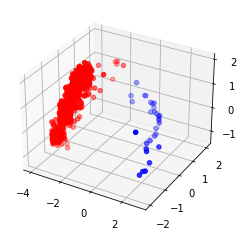

499
1000
1499


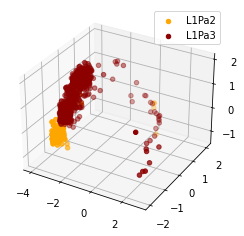

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(s_pca[c1_indx,0], s_pca[c1_indx,1], s_pca[c1_indx,2], c=colors[0])
ax.scatter(s_pca[c2_indx,0], s_pca[c2_indx,1], s_pca[c2_indx,2], c=colors[1])

plt.show()


print(len(family_indx[msa_1]))
print(len(family_indx[msa_2]))
print(len(indx_12_full))

fig = plt.figure()
ax = plt.axes(projection='3d')
# plot the sequence points for both families                                                                           
ax.scatter(s_pca[gp1_indx,0], s_pca[gp1_indx,1], s_pca[gp1_indx,2], color=line1_colors[msa_1],label=lp_names[msa_1])  
ax.scatter(s_pca[gp2_indx,0], s_pca[gp2_indx,1], s_pca[gp2_indx,2], color=line1_colors[msa_2],label=lp_names[msa_2])    
plt.legend()
plt.show()

In [8]:
# Get Silhouette Coefficient
# https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=2): {silhouette_score(s_pca_gp12, clustering.labels_)}')

Silhouette Score(n=2): 0.7484624510046063


## Generate w_ER for Clusters

In [9]:
# cluster 1
# number of positions

n_var_c1 = s0[gp1_indx].shape[1]
n_seq_c1 = s0[gp1_indx].shape[0]
n_var_c2 = s0[gp2_indx].shape[1]
n_seq_c2 = s0[gp2_indx].shape[0]

print("Number of residue positions:",n_var_c1, n_var_c2)
print("Number of sequences:",n_seq_c1, n_seq_c2)
if n_var_c1 != n_var_c2:
    sys.exit()
# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var_c1)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var_c1


Number of residue positions: 101 101
Number of sequences: 499 1000
Number of different amino acids at each position [16 11  7 11 16 14 18 15 12 13 17 15 12 14 15 13 13 17 16 11 18 16 15 11
 17 12 12 11 12 14 16 16 12 13 22 13 16 18 13  9 13 12 10 15 13 15  1 13
 15  1 15 13 17 16 13 15 16 13  1 16 18 12 18 13 12 16 16 11 13 12 13 12
 13 14 12 12  9 14  1 12 16 13 14 11 12 12 14 13 12 14 14  7 14 13 13 10
 13 10 14 14 13]
Total number of variables 1324


In [10]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER    

# s_centered = s - s.mean(axis=0)      

s_c1 = s[c1_indx]
s_c2 = s[c2_indx]
           

# Expectation Reflection                                                                                 
#=========================================================================================#
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                                                                                        


w1_file = "%s/w_line1ex_c1.npy" % (line1_dir)  
b1_file = "%s/b_line1ex_c1.npy" % (line1_dir)  
w2_file = "%s/w_line1ex_c2.npy" % (line1_dir)        
b2_file = "%s/b_line1ex_c2.npy" % (line1_dir)  

# if os.path.exists(w1_file) and not create_new:                                                          
if 0:                                                                                                    
    w_ER1 = np.load(w1_file)        
    w_ER2 = np.load(w2_file)                                                                               
    b1 = np.load(b1_file)        
    b2 = np.load(b2_file)        

else:   
    ## CLUSTER 1
    # Define weight matrix with variable for each possible amino acid at each sequence position               
    w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
    h0 = np.zeros(mx.sum())  
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_c1,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var_c1))                                                                      
                                                                                                         
    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var_c1):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    
        
        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]
        
        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      
        
    # make w symmetric                                                                                   
    w_ER1 = (w_ER + w_ER.T)/2.                                                                            
    b1 = h0
    np.save(w1_file, w_ER1)
    np.save(b1_file, b1)

    
    ## CLUSTER 2
    # Define weight matrix with variable for each possible amino acid at each sequence position               
    w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
    h0 = np.zeros(mx.sum())  
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_c2,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var_c1))                                                                      
                                                                                                         
    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var_c1):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    
        
        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]
        
        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      
        
    # make w symmetric                                                                                   
    w_ER2 = (w_ER + w_ER.T)/2.                                                                            
    b2 = h0

    np.save(w2_file, w_ER1)
    np.save(b2_file, b2)


/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 50.93743544258177
run time: 14.612576658837497


In [11]:
  # Get W-er for all families
w_families = []
b_families = []
for msa_id in range(7):
    w_file = "%s/w_%s.npy" % (line1_dir,lp_names[msa_id])        
    w_fam = np.load(w_file)
    w_families.append(w_fam)
    b_file = "%s/b_%s.npy" % (line1_dir,lp_names[msa_id])        
    b_fam = np.load(b_file)
    b_families.append(b_fam)
print(h0.shape)
print(w_ER.shape)

(1324,)
(1324, 1324)


In [12]:
from scipy.spatial import distance

# def E(i1i2, s, w):
#     E = 0
#     s_len = len(i1i2)
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s[i1:i2]
#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]
#             sj_vec = s[j1:j2]
#             E += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
#     return E

# print(E(i1i2, s[1,:], w_ER))

# def E(i1i2, s, w):
#     E = 0
#     s_len = len(i1i2)
# #     print(i1i2)
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s[i1:i2]
        
# #         # Create array for local field once.
# #         Hi = np.array([np.dot(w[i1:i2,i1i2[jB,0]:i1i2[jB,1]], np.transpose(s[i1i2[jB,0]:i1i2[jB,1]])) for jB in range(s_len)] )

#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]
#             sj_vec = s[j1:j2]
#             Hij = np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec))
# # #             print('si: ',si_vec.shape)
# #             print('Hij: ', Hij.shape)
# #             print('log(cosh(Hi))',np.log(2 * np.cosh(Hij)).shape)
        
# #             E += np.dot(si_vec, Hij - np.log(2 * np.cosh(Hij)))
#             E += np.dot(si_vec, Hij) - np.dot(si_vec,np.log(2 * np.cosh(Hij)))
#     return E


# print(E(i1i2, s[1,:], w_ER))

# def energy_diff(i1i2, s1, s2, w):
#     e_diff = 0.
#     s_len = len(i1i2)

#     E1 = E(i1i2, s1, w)
#     E2 = E(i1i2, s2, w)
#     #print(E1)
#     #print(E2)
    
#     e_diff1 = 0
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s1[i1:i2]
#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]
#             sj_vec = s2[j1:j2]
#             e_diff1 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    
#     e_diff2 = 0
#     for i in range(s_len):
#         i1,i2 = i1i2[i,0],i1i2[i,1]
#         si_vec = s2[i1:i2]
#         for j in range(s_len):
#             j1,j2 = i1i2[j,0],i1i2[j,1]
#             sj_vec = s1[j1:j2]
#             e_diff2 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
#     return E1 + E2 - e_diff1 - e_diff2   



# Proplerly defined Energy.. 1/24/2023

def col_H(i, i1i2, w, b, s):
    for ii, (i1,i2) in enumerate(i1i2):
        if i in range(i1,i2):
            break
    
    H_i = 0
    for j in range(len(s)):
        if j in range(i1,i2):
            continue
        H_i +=  w[i,j] * s[j] # + b[j]
    return H_i

def E_parallel(i1i2, s, w, b, s2=None):
    s_len = len(s)
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = 20-2)(delayed(col_H)                                                   
        (i0, i1i2, w, b, s)
        for i0 in range(s_len)) 
#     print(np.array(resH).shape)
    H_array = resH
#     print(s)
#     print(max([max(wl) for wl in w]), min([min(wl) for wl in w]))
#     print(max(b), min(b))
#     print(max(H_array), min(H_array))
#     print('Calculated H for sequence')

    coshH = np.sum(np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]))
    
    E_array = []
    if s2 is not None:
        sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ]))
        E_array  = np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]) 
        - np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ])
    else:
        sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ]))
        E_array  = np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]) 
        - np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ])

    E = coshH - sum_sigH

    return E, E_array
   
def energy_diff(i1i2, s1, s2, w, b, return_pos_array=False):
    e_diff = 0.
    s_len = len(s1)
    
    E1,E1_array = E_parallel(i1i2, s1, w, b)
    E2,E2_array = E_parallel(i1i2, s2, w, b)

    if s_len != len(s2):
        print('sequences not comparable!')
        sys.exit(24)

    Ediff1, Ediff1_array = E_parallel(i1i2, s1, w, b, s2=s2)
    Ediff2, Ediff2_array = E_parallel(i1i2, s2, w, b, s2=s1)
    
    E_diff = E1 + E2 - Ediff1 - Ediff2
    E_diff_array = E1_array + E2_array - Ediff1_array - Ediff2_array
    if return_pos_array:
        return E_diff, E_diff_array
    else:
        return E_diff

print('identity energy difference: ', energy_diff(i1i2,s_c1[1,:],s_c1[1,:],w_ER1 ,b1))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_c1[1,:],s_c1[2,:],w_ER1, b1))
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_c1[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s_c1[1,:],s_c1[2,:]], 'hamming'))[0][1])


identity energy difference:  0.0
seq 1 vs 2 energy difference:  -3.5836321788233363
seq 1 vs seq2 hamming distance:  [[0.        0.0060423]
 [0.0060423 0.       ]]
0.006042296072507553


In [13]:

# # get Energy measure by column.
# def col_E(i, H_array, s):
#     print(i)
#     col_E = 0
#     Hrest = H_array[i]

# #     for (i1, i2) in i1i2:
# #         if i in range(i1,i2):
# #             break
#     return s[i] * Hrest

# def col_H(i, i1i2, w, b, s):
#     for ii, (i1,i2) in enumerate(i1i2):
#         if i in range(i1,i2):
#             break
    
#     H_i = 0
#     for j in range(len(s)):
#         if j in range(i1,i2):
#             continue
#         H_i +=  w[i,j] * s[j] # + b[j]
#     return H_i


# def col_2coshH(i, i1i2, s):
#     for ii, (i1, i2) in enumerate(i1i2):
#         if i in range(i1,i2):
#             break
# #     return np.sum(np.array([w[i,j]*s[j] + b[i] for j in range(len(s)) if j not in range(i1,i2)]))
#     return 


# def E_parallel(i1i2, s, w, b, s2=None):
#     s_len = len(s)
    
#     # Caluculate Hi for every column of H, includeing bias.
#     resH = Parallel(n_jobs = 20-2)(delayed(col_H)                                                   
#         (i0, i1i2, w, b, s)
#         for i0 in range(s_len)) 
# #     print(np.array(resH).shape)
#     H_array = resH
# #     print(s)
# #     print(max([max(wl) for wl in w]), min([min(wl) for wl in w]))
# #     print(max(b), min(b))
# #     print(max(H_array), min(H_array))
# #     print('Calculated H for sequence')

#     coshH = np.sum(np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]))
    
#     E_array = []
#     if s2 is not None:
#         sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ]))
#         E_array.append(coshH - sum_sigH)
#     else:
#         sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ]))
#         E_array.append(coshH - sum_sigH)

    
#     return np.sum(np.array(E_array)), np.array(E_array)
            
# # def E(i1i2, s, w):
# #     E = 0
# #     s_len = len(s)
# #     for i in range(s_len):
# #         print(i)
# #         for (i1, i2) in i1i2:
# #             if i in range(i1,i2):
# #                 break
# #         print(i1,i2)
# #         for j in range(s_len):
# #             if j == i:
# #                 continue
# #             Hrest = np.sum([w[i,jB]*s[jB] for jB in range(s_len) if jB not in range(i1,i2)])
        
# #             E += s[i] * Hrest - np.log(2 * np.cosh(Hrest))
# #     return E


# # def energy_diff(i1i2, s1, s2, w):
# #     e_diff = 0.
# #     s_len = len(s1)
# #     if s_len != len(s2):
# #         print('sequences not comparable!')
# #         sys.exit(24)

# #     E1, E1_array = E_parallel(i1i2, s1, w)
# #     E2, E2_array = E_parallel(i1i2, s2, w)
# #     #print(E1)
# #     #print(E2)
    
# #     e_diff1 = 0
# #     for i in range(s_len):
# #         for (i1, i2) in i1i2:
# #             if i in range(i1,i2):
# #                 break
# #         for j in range(s_len):
# #             if j in range(i1,i2):
# #                 continue
# #             Hrest = np.sum([w[i,jB]*s2[jB] for jB in range(s_len) if jB not in range(i1,i2)])
# #             e_diff1 += s1[i] * Hrest - np.log(2 * np.cosh(Hrest))
         
# #     e_diff2 = 0
# #     for i in range(s_len):
# #         for (i1, i2) in i1i2:
# #             if i in range(i1,i2):
# #                 break
# #         for j in range(s_len):
# #             if j in range(i1,i2):
# #                 continue
# #             Hrest = np.sum([w[i,jB]*s1[jB] for jB in range(s_len) if jB not in range(i1,i2)])
# #             e_diff1 += s2[i] * Hrest - np.log(2 * np.cosh(Hrest))

# #     return E1 + E2 - e_diff1 - e_diff2   
# def energy_diff(i1i2, s1, s2, w, b):
#     e_diff = 0.
#     s_len = len(s1)
    
#     E1,E1_array = E_parallel(i1i2, s1, w, b)
#     E2,E2_array = E_parallel(i1i2, s2, w, b)

#     if s_len != len(s2):
#         print('sequences not comparable!')
#         sys.exit(24)

#     Ediff1, Ediff1_array = E_parallel(i1i2, s1, w, b, s2=s2)
#     Ediff2, Ediff2_array = E_parallel(i1i2, s2, w, b, s2=s1)
    
#     E_diff = E1 + E2 - Ediff1 - Ediff2
#     E_diff_array = E1_array + E2_array - Ediff1_array - Ediff2_array

#     return E_diff, E_diff_array

# print('Expectation (Energy) of s: ', E_parallel(i1i2, s_c1[0,:], w_ER1, b1)[0])


# print('identity energy difference: ', energy_diff(i1i2,s_c1[1,:],s_c1[1,:],w_ER1, b1)[0])
# print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_c1[1,:],s_c1[2,:],w_ER1, b1)[0])
# print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_c1[1:3,:], 'hamming')))
# print(distance.squareform(distance.pdist([s_c1[1,:],s_c1[2,:]], 'hamming'))[0][1])


In [14]:
c1_position_energy = []
for onehot_seq in s[c1_indx]:
    c1_position_energy.append(E_parallel(i1i2, onehot_seq, w_ER1, b1)[1])
    
c2_position_energy = []
for onehot_seq in s[c2_indx]:
    c2_position_energy.append(E_parallel(i1i2, onehot_seq, w_ER2, b2)[1])
    
        

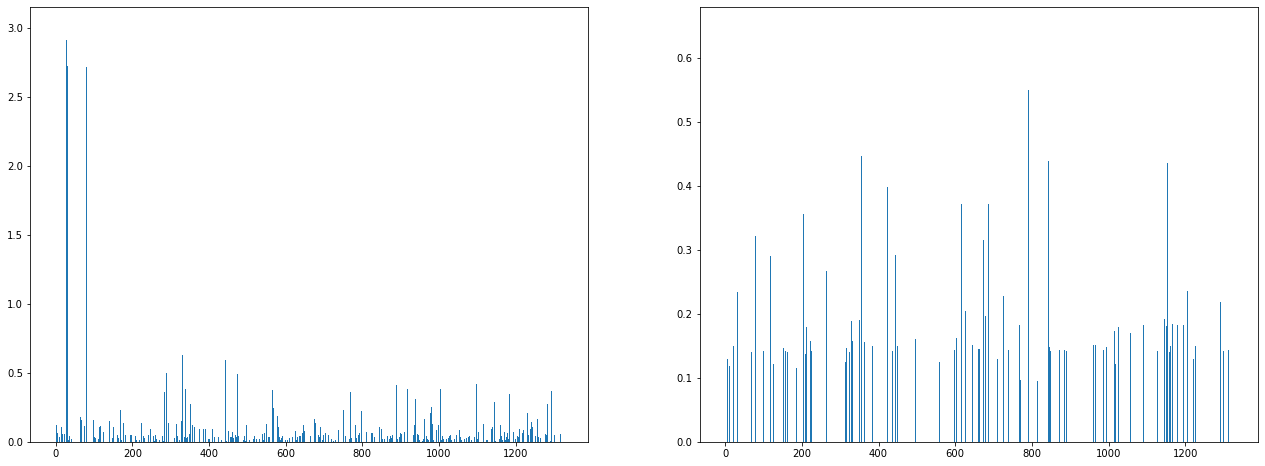

In [15]:
# plot position-specific energy contribution
c1_posE_mat = np.array(c1_position_energy)
c2_posE_mat = np.array(c2_position_energy)

positions = [i for i in range(len(c1_posE_mat[0]))]
fig = plt.figure(figsize=(22,8))
ax1  = fig.add_subplot(121)    
ax2  = fig.add_subplot(122)    
ax1.bar(positions, c1_posE_mat.std(axis=0))
ax2.bar(positions, c2_posE_mat.std(axis=0))

plt.show()


In [16]:
from direct_info import direct_info
from scipy.spatial import distance

di_c1 = direct_info(s0[c1_indx], w_ER1)
di_c2 = direct_info(s0[c2_indx], w_ER2)

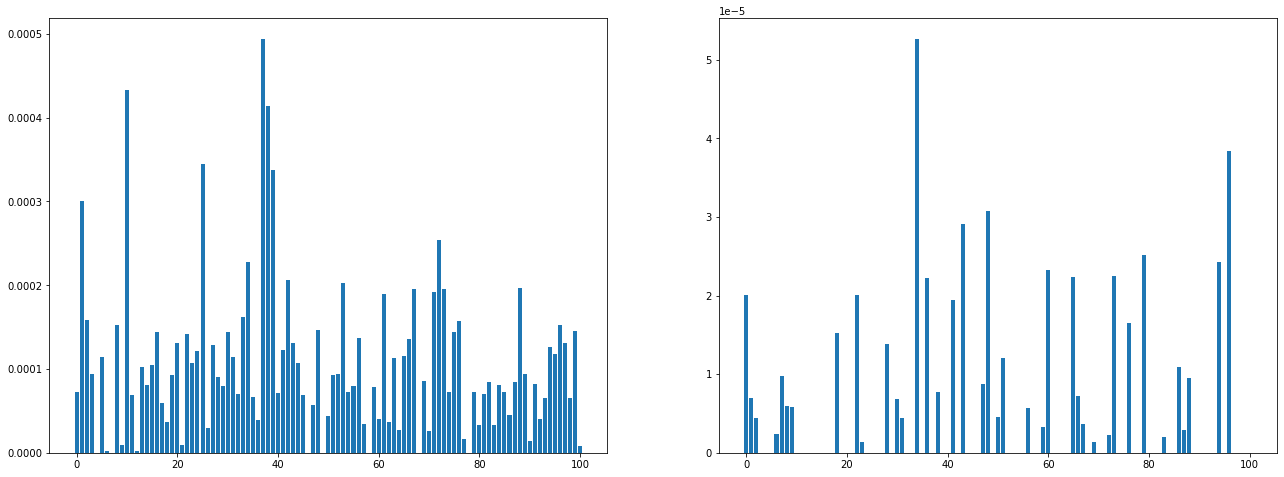

In [17]:
positions = [i for i in range(len(di_c1[0]))]
fig = plt.figure(figsize=(22,8))
ax1  = fig.add_subplot(121)    
ax2  = fig.add_subplot(122)    
ax1.bar(positions, di_c1.mean(axis=0))
ax2.bar(positions, di_c2.mean(axis=0))

plt.show()

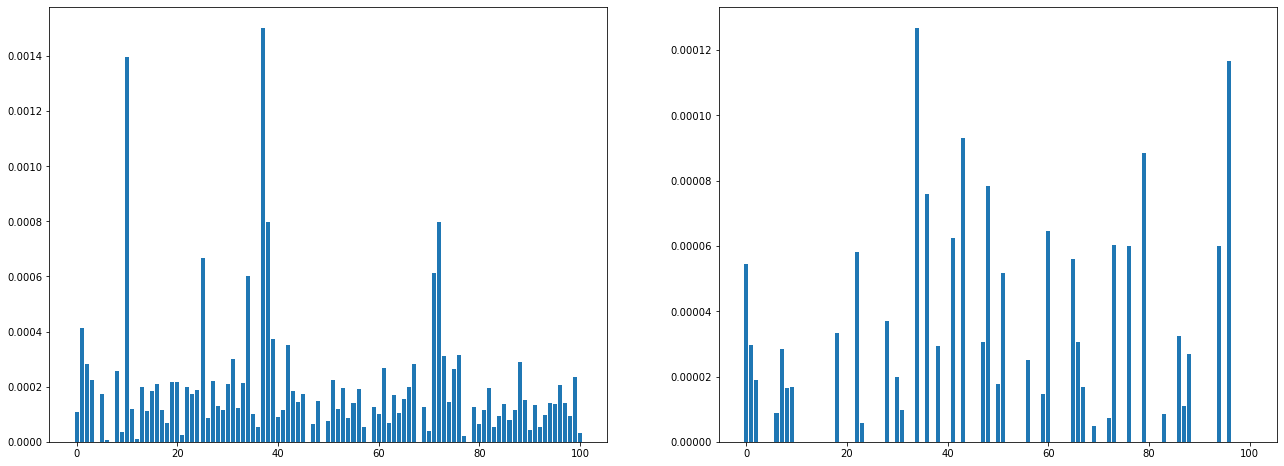

In [18]:
positions = [i for i in range(len(di_c1[0]))]
fig = plt.figure(figsize=(22,8))
ax1  = fig.add_subplot(121)    
ax2  = fig.add_subplot(122)    
ax1.bar(positions, di_c1.std(axis=0))
ax2.bar(positions, di_c2.std(axis=0))

plt.show()

In [19]:
# Generate E differences between all sequences of clusters 1 and 2
n_cpus=20
c1_mean = np.mean(s[c1_indx],axis=0)

c2_mean = np.mean(s[c2_indx],axis=0)

# if not os.path.exists('C1_SvsAVG_energy.npy'):
if 0:
    print('getting mean energy difference field for cluster 1')

    res1 = Parallel(n_jobs = n_cpus-2)(delayed(energy_diff)(i1i2,c1_mean,s[i0,:],w_ER1,b1)
                   for i0 in range(len(s)))
    np.save('C1_SvsAVG_energy.npy' ,res1)
    s_E_c1 = res1

    print('getting mean energy difference field for cluster 2')

    res2 = Parallel(n_jobs = n_cpus-2)(delayed(energy_diff)(i1i2,c2_mean,s[i0,:],w_ER2, b2)
                   for i0 in range(len(s)))
    np.save('C2_SvsAVG_energy.npy' ,res2)
    s_E_c2 = res2
else:
    s_E_c1 = np.load('C1_SvsAVG_energy.npy')
    s_E_c2 = np.load('C2_SvsAVG_energy.npy')


In [20]:
s_E_rows = []
for i in range(len(w_families)):
    s_E_rows.append(np.load(furano_dir + '/gp%d_SvsAVG_energy.npy' % i))
print(s_E_rows)
s_E_row = s_E_rows[msa_1]

[array([ 24.44301347,  27.79126895,  24.27315772, ...,  98.02799409,
        96.45346889, 108.96599635]), array([46.81981363, 50.67662778, 52.82805404, ..., 88.15683516,
       80.69000154, 89.21925056]), array([ 44.66858802,  53.37931359,  53.37717257, ..., 208.34970723,
       190.35574498, 221.66637629]), array([79.10540189, 76.22426904, 80.89760607, ..., 66.09061159,
       71.06826151, 88.75954692]), array([157.96575803, 133.95610363, 150.82250472, ...,  41.67675242,
        22.6893948 ,  30.52510628]), array([160.26492186, 147.42828268, 159.46631434, ...,  50.44681076,
        43.39304256,  49.38396848]), array([110.4619828 , 121.40313527, 123.09299434, ...,  56.58325264,
        57.36896073,  48.58293121])]


4341
x (4341,)
y (4341,)
x (4341,)
y (4341,)
x (4341,)
y (4341,)


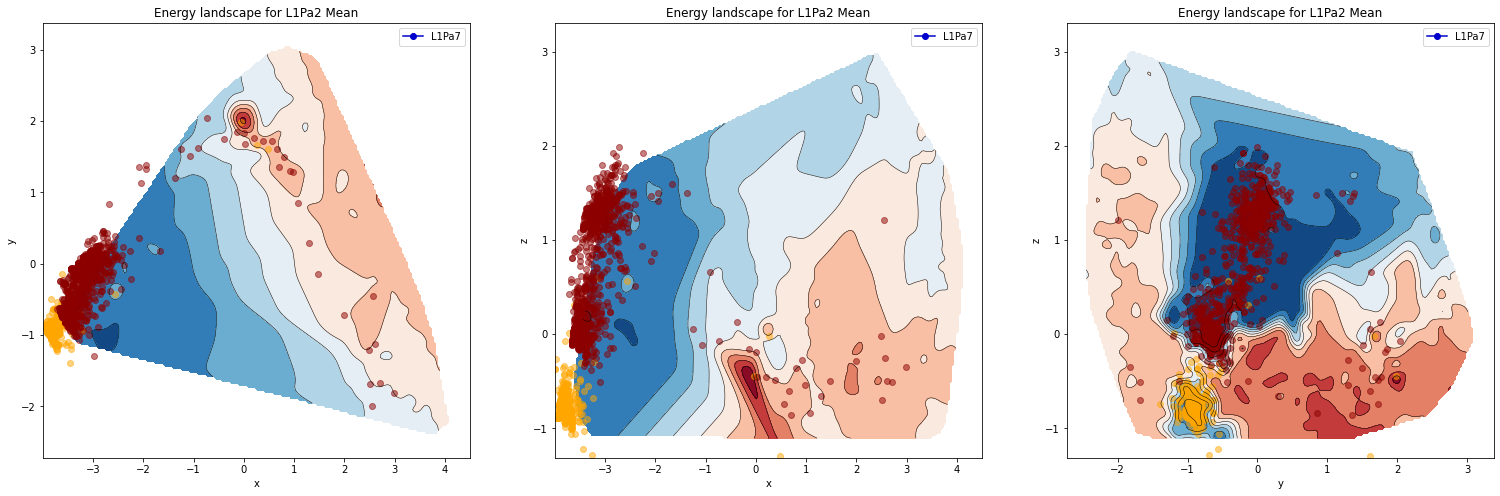

In [21]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri
from matplotlib.lines import Line2D


legend_elements = [Line2D([0], [0], color=line1_colors[i], marker='o', label=lp_names[i]) for i in range(7)]

s0_len = len(s0)


fig1 = plt.figure(figsize=(26,8))

ax1  = fig1.add_subplot(131)    
ax2  = fig1.add_subplot(132)    
ax3  = fig1.add_subplot(133)    
    

msa_1 = 1
msa_2 =msa_1+1

gp1_mean = np.mean(s[gp1_indx],axis=0)
gp2_mean = np.mean(s[gp2_indx],axis=0)
w_gp1 = w_families[msa_1]
w_gp2 = w_families[msa_2]


gp1_mean_pca = pca.transform([gp1_mean])[0]

z = s_E_rows[msa_1]
print(len(s_E_rows[msa_1]))
#     print('%d energy: ' % msa_1, z1)
#     print('%d energy: ' % msa_2, z2)

planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1, ax2, ax3]  # panel 1 to plot the different planes for msa 1

for dim in range(3):
    x = s_pca[:,planes[dim][0]]
    y = s_pca[:,planes[dim][1]]
    print('x', x.shape)
    print('y', y.shape)

    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)


    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)

    interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


    Xi, Yi = np.meshgrid(xi, yi)

    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)
  

    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    axes[dim].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr11 = axes[dim].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


    # plot the sequence points for both families
    axes[dim].scatter(s_pca[gp1_indx,planes[dim][0]], s_pca[gp1_indx,planes[dim][1]], color=line1_colors[msa_1],alpha=.5)  
    axes[dim].scatter(s_pca[gp2_indx,planes[dim][0]], s_pca[gp2_indx,planes[dim][1]], color=line1_colors[msa_2],alpha=.5)                                                                               

    ## Sandbox 
#     # plot the mean value perturbed and the boundary sequence of the descendant
#     # fin closest descendant
#     min_dist = 100000.
#     for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
#         pt_dist = pdist((gp1_mean,msa2_seq))
#         if pt_dist < min_dist:
#             min_dist = pt_dist
#             min_id = ii
#     boundary_seq = s[family_indx[msa_2]][min_id]
#     boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]

#     wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
#     pca_wER_pert = pca.transform(wER_pert)

#     cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
#     if cos_theta > 0.:        
#         ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='g')
#     else:
#         ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='r')
#     axes1[dim].scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
#     axes1[dim].scatter(gp1_mean_pca[planes[dim][0]], gp1_mean_pca[planes[dim][1]], marker='^',color='k',s=100)
#     axes1[dim].scatter(boundary_seq_pca[planes[dim][0]], boundary_seq_pca[planes[dim][1]], marker='*',color='k',s=100)


    axes[dim].legend(handles=legend_elements[i:i+2])
    axes[dim].set_title('Energy landscape for %s Mean'% lp_names[msa_1])
    axes[dim].set_xlabel(ax_labels[planes[dim][0]])
    axes[dim].set_ylabel(ax_labels[planes[dim][1]])
        
        

4341
x (4341,)
y (4341,)
x (4341,)
y (4341,)
x (4341,)
y (4341,)


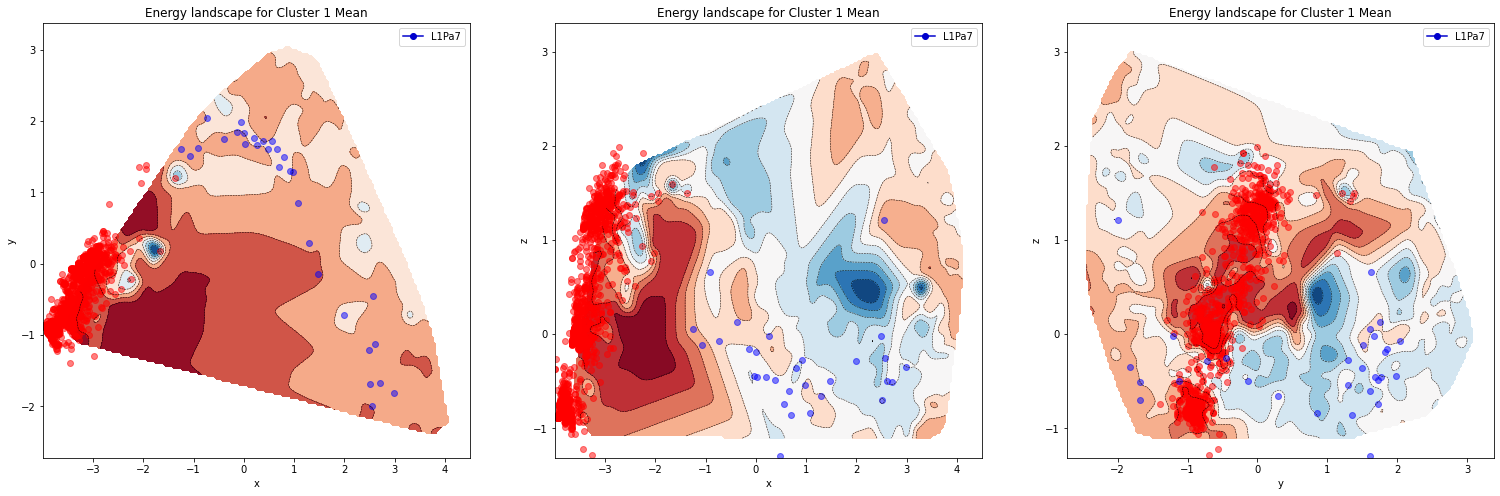

In [22]:
# Cluster 1 perspective
s0_len = len(s0)



fig1c = plt.figure(figsize=(26,8))

ax1c  = fig1c.add_subplot(131)    
ax2c  = fig1c.add_subplot(132)    
ax3c  = fig1c.add_subplot(133)    

z = s_E_c1
print(len(s_E_c1))
#     print('%d energy: ' % msa_1, z1)
#     print('%d energy: ' % msa_2, z2)

planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1c, ax2c, ax3c]  # panel 1 to plot the different planes for msa 1

for dim in range(3):
    x = s_pca[:,planes[dim][0]]
    y = s_pca[:,planes[dim][1]]
    print('x', x.shape)
    print('y', y.shape)

    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)


    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)

    interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


    Xi, Yi = np.meshgrid(xi, yi)

    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)
  

    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    axes[dim].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr11 = axes[dim].contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


    # plot the sequence points for both families
    axes[dim].scatter(s_pca[c1_indx,planes[dim][0]], s_pca[c1_indx,planes[dim][1]], color=colors[0],alpha=.5)  
    axes[dim].scatter(s_pca[c2_indx,planes[dim][0]], s_pca[c2_indx,planes[dim][1]], color=colors[1],alpha=.5)                                                                               

    ## Sandbox 
#     # plot the mean value perturbed and the boundary sequence of the descendant
#     # fin closest descendant
#     min_dist = 100000.
#     for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
#         pt_dist = pdist((gp1_mean,msa2_seq))
#         if pt_dist < min_dist:
#             min_dist = pt_dist
#             min_id = ii
#     boundary_seq = s[family_indx[msa_2]][min_id]
#     boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]

#     wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
#     pca_wER_pert = pca.transform(wER_pert)

#     cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
#     if cos_theta > 0.:        
#         ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='g')
#     else:
#         ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='r')
#     axes1[dim].scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
#     axes1[dim].scatter(gp1_mean_pca[planes[dim][0]], gp1_mean_pca[planes[dim][1]], marker='^',color='k',s=100)
#     axes1[dim].scatter(boundary_seq_pca[planes[dim][0]], boundary_seq_pca[planes[dim][1]], marker='*',color='k',s=100)


    axes[dim].legend(handles=legend_elements[i:i+2])
    axes[dim].set_title('Energy landscape for Cluster 1 Mean')
    axes[dim].set_xlabel(ax_labels[planes[dim][0]])
    axes[dim].set_ylabel(ax_labels[planes[dim][1]])
        


4341
x (4341,)
y (4341,)


Text(0, 0.5, 'y')

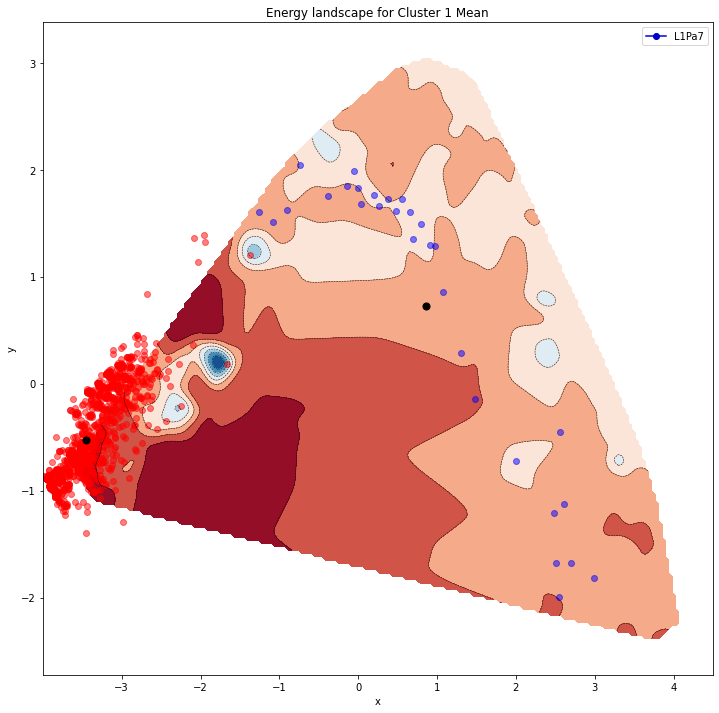

In [23]:

# Cluster 1 perspective
s0_len = len(s0)


fig1c = plt.figure(figsize=(12,12))

ax1c  = fig1c.add_subplot(111)    
c1_mean_pca = pca.transform([c1_mean])[0]
c2_mean_pca = pca.transform([c2_mean])[0]

z = s_E_c1
print(len(s_E_c1))
#     print('%d energy: ' % msa_1, z1)
#     print('%d energy: ' % msa_2, z2)

planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']

x = s_pca[:,0]
y = s_pca[:,1]
print('x', x.shape)
print('y', y.shape)

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)


# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)

interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


Xi, Yi = np.meshgrid(xi, yi)

zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)


# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
ax1c.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = ax1c.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")


# plot the sequence points for both families
ax1c.scatter(s_pca[c1_indx,0], s_pca[c1_indx,1], color=colors[0],alpha=.5)  
ax1c.scatter(s_pca[c2_indx,0], s_pca[c2_indx,1], color=colors[1],alpha=.5)                                                                               

ax1c.scatter(c1_mean_pca[0], c1_mean_pca[1], c='k',s=50)  
ax1c.scatter(c2_mean_pca[0], c2_mean_pca[1], c='k',s=50)                                                                               


## Sandbox 
#     # plot the mean value perturbed and the boundary sequence of the descendant
#     # fin closest descendant
#     min_dist = 100000.
#     for ii, msa2_seq in enumerate(s[family_indx[msa_2]]):
#         pt_dist = pdist((gp1_mean,msa2_seq))
#         if pt_dist < min_dist:
#             min_dist = pt_dist
#             min_id = ii
#     boundary_seq = s[family_indx[msa_2]][min_id]
#     boundary_seq_pca = pca_s[family_indx[msa_2]][min_id]

#     wER_pert = move_seq(w_gp1, gp1_mean, move_dim='min')
#     pca_wER_pert = pca.transform(wER_pert)

#     cos_theta = check_angle(gp1_mean, wER_pert[-1], boundary_seq)
#     if cos_theta > 0.:        
#         ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='g')
#     else:
#         ax1.plot(pca_wER_pert[:,planes[dim][0]], pca_wER_pert[:,planes[dim][1]], color='r')
#     axes1[dim].scatter(pca_wER_pert[-1,0], pca_wER_pert[-1,1],marker='^',color='k')
#     axes1[dim].scatter(gp1_mean_pca[planes[dim][0]], gp1_mean_pca[planes[dim][1]], marker='^',color='k',s=100)
#     axes1[dim].scatter(boundary_seq_pca[planes[dim][0]], boundary_seq_pca[planes[dim][1]], marker='*',color='k',s=100)


ax1c.legend(handles=legend_elements[i:i+2])
ax1c.set_title('Energy landscape for Cluster 1 Mean')
ax1c.set_xlabel(ax_labels[0])
ax1c.set_ylabel(ax_labels[1])